# Training a GPT model on protein sequences

Compared to Shakespeare, we implement a few changes:

* We want to train the model to predict protein sequences in isolation from one another; i.e. independent of the sequences shown before.
* We want to handle the case where proteins have variables sizes, and some are shorter than the block size. To handle variable-sized proteins in batches we'll use padding with a special token and mask it later on to block the attention mechanism from/to this special token.
* We want to use PyTorch Lightning to make our life a little easier.

In [20]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
import random
from collections import Counter
import matplotlib.pyplot as plt

from nano_transformer import NanoTransformer


fname = "data/prot_seqs.txt"

# hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32 if device == "cpu" else 64
block_size = 8 if device == "cpu" else 256  # context size
n_embd = 16 if device == "cpu" else 384  # called d_model in paper
n_blocks = 2 if device == "cpu" else 6  # number N of transformer blocks
# head_size = 32  # called d_k = d_v
num_heads = 2 if device == "cpu" else 6  # nr attention heads
dropout = 0.2
max_iters = 5000
eval_interval = 500 if device == "cpu" else 10
learning_rate = 1e-3 if device == "cpu" else 3e-4

eval_iters = 200
print(f"device: {device}")

device: cpu


In [27]:
with open(fname, "r") as f:
    lines = f.readlines()

### Encoding amino acid tokens

Note: There are 24 amino acids in this dataset.
`{'U', 'X', 'O', 'Z'}` are present but not "commonly" known amino acids
See: https://en.wikipedia.org/wiki/FASTA_format for meaning.

In addition:
* `\n` means "end of protein"
* `!` is our special padding token

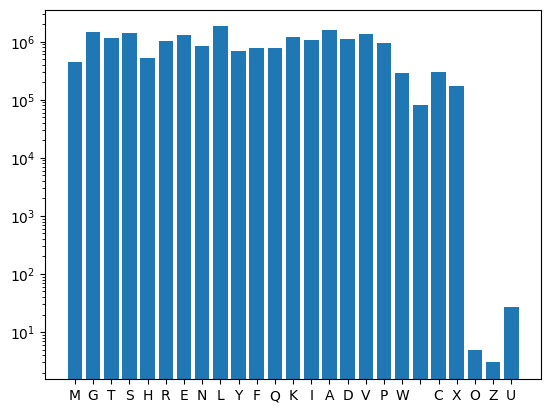

In [35]:
pad = "!"  # padding character
flat_text = [c for line in lines for c in line]  # all proteins concatenated
chars = sorted(set(flat_text)) + [pad]
vocab_size = len(chars)
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}



counter = Counter(flat_text)
plt.bar(counter.keys(), counter.values(), log=True);


In [57]:
def encode(s):    
    return [stoi[c] for c in s]

def decode(i):
    return "".join([itos[ii] for ii in i])

def encode_batch(batch_lines):
    # encode with padding to either block_size+1 or max_length+1
    encodings = [encode(line) for line in batch_lines]
    max_length = max([len(line) for line in encodings])
    final_length = max(block_size+1, max_length+1)
    for encoding in encodings:
        if len(encoding) < final_length:
            encoding += [stoi[pad]] * (final_length - len(encoding))
    return encodings

### Train / val split

In [58]:
random.seed(1337)

# There is one line per protein.
# We shuffle for train/val split (done in place).
random.shuffle(lines)

n = int(0.9 * len(lines))
train_lines = lines[:n]
val_lines = lines[n:]

### Data loader

TODO: return lengths of each sequences in order to know how to mask later on

In [116]:
def get_batch(batch_size, block_size, split):
    # generate a small batch of data of inputs x and targets y
    lines_to_consider = train_lines if split == "train" else val_lines

    # ids of proteins in batch
    prot_idxs = [random.randint(0, len(lines_to_consider) - 1) for _ in range(batch_size)]
    batch_lines = [lines_to_consider[i] for i in prot_idxs]

    # encode with padding to max(block_size+1, max_length+1)
    prots_encoded = encode_batch(batch_lines)

    # get random start positions for each protein; make sure we don't fetch subsequences made of padding
    start_idxs = [random.randint(0, max(0, len(batch_lines[i]) - block_size - 1))
                  for i in range(batch_size)]
    
    # build torch tensors
    x = torch.stack([torch.tensor(prots_encoded[i][start_idxs[i] : start_idxs[i] + block_size], dtype=torch.long)
                     for i in range(batch_size)])
    y = torch.stack([torch.tensor(prots_encoded[i][start_idxs[i] + 1 : start_idxs[i] + block_size + 1], dtype=torch.long) 
                     for i in range(batch_size)])

    x, y = x.to(device), y.to(device)
    return x, y

In [126]:
random.seed(3)

x, y = get_batch(2, 128, "train")

print(x)
print(y)

tensor([[ 6, 17,  6, 15,  5, 16, 20,  8,  6, 14,  6,  7, 14,  8, 16,  1, 10, 20,
          6,  3,  4,  1,  4, 10, 14,  2, 16,  8, 17, 14,  6,  9, 12,  1, 18,  6,
         11,  4, 20,  6, 21, 23, 16, 17, 14,  5, 17, 16, 20, 20,  7, 10, 23, 16,
         12,  6,  9,  3, 15,  3,  1,  4, 15,  1, 14,  4, 23, 16,  6, 16, 18,  4,
         10, 10,  9,  4, 17,  8,  6,  4,  6,  9, 20,  1, 10, 16,  8, 15, 12, 20,
         16,  5, 17,  3,  4,  6,  6, 23, 18,  2,  5,  5, 16,  3,  7, 17, 23, 15,
          4,  4,  1,  1, 20,  4, 10,  9, 20,  4,  3, 14,  5, 23, 21,  8, 12, 14,
          6, 16],
        [12, 10, 10, 11, 23, 16, 23,  9, 15, 10,  3,  6,  1, 23,  8, 12,  1, 15,
          4, 15,  6, 10,  9,  6,  1, 10,  5, 14, 11, 20, 18,  5,  3,  6,  8,  4,
          2,  7, 12,  4, 21,  4,  8, 18,  5,  4,  4,  8,  7, 16, 12,  6,  3,  8,
          1,  5,  1,  8, 23, 12, 23, 18, 16, 23, 18,  6,  3,  3, 17, 23, 20, 10,
          7,  4,  6,  1,  9, 20, 10, 18,  4,  8, 17, 16,  5, 21,  1,  3, 16, 20,
          